In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import plot_importance
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
%matplotlib inline

In [3]:
with open('ultimate_data_challenge.json') as f:
   data = json.load(f)
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
# determine min and max of last trip date and set date range to 30 days prior to max
df.last_trip_date.min()

'2014-01-01'

In [5]:
df.last_trip_date.max()

'2014-07-01'

In [6]:
df['retained'] = 0
df.retained = np.where(df.last_trip_date >= '2014-06-01', 1, 0)

# percent retained
df.retained.mean()

0.37608

In [7]:
# change city value to numeric
df['city_numeric'] = 0
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [8]:
df.city_numeric = np.where(df.city == "King's Landing", 1, np.where(df.city == "Astapor", 2, np.where(df.city == "Winterfell", 3, 0)))

In [9]:
# change phone to numeric
df['phone_numeric'] = 0
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [10]:
df.phone_numeric = np.where(df.phone == "iPhone", 1, np.where(df.phone == "Android", 2, 0))

In [11]:
# extract day of week from signup date
df['signup_datetime'] = pd.to_datetime(df.signup_date)
df['signup_weekday'] = df.signup_datetime.dt.dayofweek

In [12]:
df.corr()['retained']

avg_dist                 -0.092780
avg_rating_by_driver     -0.026791
avg_rating_of_driver     -0.011653
avg_surge                -0.003333
surge_pct                 0.011797
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
weekday_pct               0.009693
retained                  1.000000
city_numeric             -0.166180
phone_numeric            -0.217594
signup_weekday            0.000042
Name: retained, dtype: float64

In [13]:
# three dataframes will be created from original dataframe:
# 1st will convert NaN values (which exist in rating columns) to 0
# 2nd will convert NaN values to median value of rating columns
# 3rd will remove columns with low correlation

df1 = df.copy()
df1.avg_rating_by_driver = df1.avg_rating_by_driver.fillna(0)
df1.avg_rating_of_driver = df1.avg_rating_of_driver.fillna(0)

df2 = df.copy()
df2.avg_rating_by_driver = df2.avg_rating_by_driver.fillna(df2.avg_rating_by_driver.median())
df2.avg_rating_of_driver = df2.avg_rating_of_driver.fillna(df2.avg_rating_of_driver.median())

df3 = df.copy()
df3.avg_rating_by_driver = df3.avg_rating_by_driver.fillna(df3.avg_rating_by_driver.median())
df3 = df3.drop('avg_rating_of_driver', axis=1)
df3 = df3.drop('avg_surge', axis=1)
df3 = df3.drop('surge_pct', axis=1)
df3 = df3.drop('weekday_pct', axis=1)
df3 = df3.drop('signup_weekday', axis=1)

In [14]:
# create columns list for only the columns that will be used to predict target value
columns_all = df.columns.tolist()
columns_all = [c for c in columns_all if c not in ['city', 'last_trip_date', 'phone', 'signup_date', 'retained', 'signup_datetime']]
columns_small = df3.columns.tolist()
columns_small = [c for c in columns_small if c not in ['city', 'last_trip_date', 'phone', 'signup_date', 'retained', 'signup_datetime']]
target = 'retained'

In [17]:
# train, test dfs
train, test = train_test_split(df, test_size=0.2)
train1, test1 = train_test_split(df1, test_size=0.2)
train2, test2 = train_test_split(df2, test_size=0.2)
train3, test3 = train_test_split(df3, test_size=0.2)

In [23]:
# experimentation with different classification models, looking for the lowest MSE
# xgboost can handle missing data, df will be used
clfxgb = xgb.XGBClassifier().fit(train[columns_all], train[target])
predictionsxgb = clfxgb.predict(test[columns_all])
mean_squared_error(predictionsxgb, test[target])

0.21579999999999999

In [26]:
# MLPClassifier with missing values = 0
clfmlp1 = MLPClassifier().fit(train1[columns_all], train1[target])
predictionsmlp1 = clfmlp1.predict(test1[columns_all])
mean_squared_error(predictionsmlp1, test1[target])

0.24199999999999999

In [27]:
# MLPClassifier with missing values = median
clfmlp2 = MLPClassifier().fit(train2[columns_all], train2[target])
predictionsmlp2 = clfmlp2.predict(test2[columns_all])
mean_squared_error(predictionsmlp2, test2[target])

0.24629999999999999

In [31]:
# KNeighborsClassifier with missing values = 0
clfkn1 = KNeighborsClassifier().fit(train1[columns_all], train1[target])
predictionskn1 = clfkn1.predict(test1[columns_all])
mean_squared_error(predictionskn1, test1[target])

0.2606

In [32]:
# KNeighborsClassifier with missing values = median
clfkn2 = KNeighborsClassifier().fit(train2[columns_all], train2[target])
predictionskn2 = clfkn2.predict(test2[columns_all])
mean_squared_error(predictionskn2, test2[target])

0.26350000000000001

In [37]:
# SVC with missing values = median
# will use small df to speed up calculations
clfsv1 = SVC().fit(train3[columns_small], train3[target])
predictionssv1 = clfsv1.predict(test3[columns_small])
mean_squared_error(predictionssv1, test3[target])

0.25929999999999997

In [45]:
# Decision Tree classifier, which is able to handle missing values
clfdt = DecisionTreeClassifier(max_depth=5).fit(train1[columns_all], train1[target])
predictionsdt = clfdt.predict(test1[columns_all])
mean_squared_error(predictionsdt, test1[target])

0.249

In [48]:
# Random Forest classifier, which is able to handle missing values
clfrf = RandomForestClassifier().fit(train1[columns_all], train1[target])
predictionsrf = clfrf.predict(test1[columns_all])
mean_squared_error(predictionsrf, test1[target])

0.24410000000000001

In [50]:
# Ada Boost classifier, which is able to handle missing values
clfab = AdaBoostClassifier().fit(train1[columns_all], train1[target])
predictionsab = clfab.predict(test1[columns_all])
mean_squared_error(predictionsab, test1[target])

0.21870000000000001

In [52]:
# Gaussian Naive Bayes classifier, which is able to handle missing values
clfgnb = GaussianNB().fit(train1[columns_all], train1[target])
predictionsgnb = clfgnb.predict(test1[columns_all])
mean_squared_error(predictionsgnb, test1[target])

0.32140000000000002

In [54]:
# Quadratic Discriminant Analysis, which is able to handle missing values
clfqda = QuadraticDiscriminantAnalysis().fit(train1[columns_all], train1[target])
predictionsqda = clfqda.predict(test1[columns_all])
mean_squared_error(predictionsqda, test1[target])

0.32400000000000001

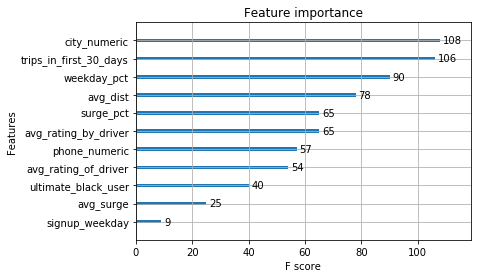

In [64]:
# overall lowest MSE belonged to xgboost
plot_importance(clfxgb)
plt.show()

In [66]:
# as city numeric had the most importance, might be worthwhile to view retention rate by city:
df.groupby('city').mean()['retained']

city
Astapor           0.255715
King's Landing    0.628134
Winterfell        0.351945
Name: retained, dtype: float64

In [ ]:
# as an answer to part 3 question 3, knowing how important the city is, along with the trips taken in the first 30 days...
# Ultimate could examine what works in King's Landing and try to increase retention in other cities.
# trips_in_first_30_days has a positive correlation, so when someone signs up, it'd be good for retention to keep an eye...
# on their transaction history and how much they're using the service.